# Quantum Large Language Model Fine Tuning : a walkthrough with TorchQuantum and MerLin

This notebook demonstrates the different model architectures available in the QLLM framework from `main.py`. The framework supports both quantum and classical approaches for text classification with pre-trained embeddings.

## Available Model Types

The framework supports 8 different model choices:

### Quantum Models (MerLin Framework)
1. **merlin-basic** - Basic quantum classifier using photonic quantum computing
2. **merlin-parallel** - Parallel quantum encoding approach
3. **merlin-expectation** - Expectation-based quantum classifier
4. **merlin-kernel** - Quantum kernel method with SetFit

### Quantum Models (TorchQuantum)
5. **torchquantum** - Variational quantum circuit approach (from [Quantum Large Language Model Fine-Tuning](https://arxiv.org/abs/2504.08732))

### Classical Models
6. **mlps** - Multi-layer perceptrons with varying hidden dimensions
7. **svm** - Support Vector Machine with different parameter configurations
8. **log-reg** - Logistic Regression


## Setup and Imports

First, let's import the necessary modules and set up the environment:

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Import QLLM modules
from classical_utils import MLPClassifier
from data_utils import create_dataset_from_embeddings
from merlin_kernel import create_setfit_with_q_kernel
from merlin_llm_utils import (
    QuantumClassifier,
    QuantumClassifierExpectation,
    QuantumClassifierParallel,
)
from torch.utils.data import DataLoader
from torchquantum_utils import QLLM

print("All modules imported successfully!")

All modules imported successfully!


## Configuration Setup

Let's create a configuration class to easily switch between different models:

In [22]:
class Config:
    def __init__(self, model_type="merlin-basic"):
        # Dataset parameters
        self.dataset = "sst2"
        self.samples_per_class = 8
        self.eval_size = 250

        # Model parameters
        self.model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
        self.embedding_dim = 768
        self.hidden_dim = 100

        # Training parameters
        self.epochs = 50
        self.learning_rate = 1e-3
        self.batch_size = 16
        self.kernel_batch_size = 32

        # Model choice
        self.model = model_type

        # MerLin parameters
        self.quantum_modes = 10
        self.no_bunching = False
        self.photons = 0  # 0 means modes/2
        self.input_state = None

        # TorchQuantum parameters
        self.encoder_configs = [
            {"n_qubits": 10, "n_layers": 1, "connectivity": 1},
            {"n_qubits": 10, "n_layers": 1, "connectivity": 1},
        ]
        self.pqc_config = [
            {"n_qubits": 10, "n_main_layers": 2, "connectivity": 1, "n_reuploading": 2}
        ]

        # Parallel encoding dimension
        self.e_dim = 1

        # Execution parameters
        self.seed = 42
        self.device = "auto"
        self.verbose = True


# Create a default configuration
config = Config()
print(f"Configuration created for model: {config.model}")

Configuration created for model: merlin-basic


## Device Setup

Set up the computing device and random seeds:

In [23]:
def setup_environment(config):
    """Set up random seeds and device"""
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)

    if config.device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(config.device)

    print(f"Using device: {device}")
    print("Configuration:")
    print(f"- Samples per class: {config.samples_per_class}")
    print(f"- Training epochs: {config.epochs}")
    print(f"- Learning rate: {config.learning_rate}")
    print(f"- Embedding dimension: {config.embedding_dim}")
    print(f"- Hidden dimension: {config.hidden_dim}")

    return device


device = setup_environment(config)

Using device: cpu
Configuration:
- Samples per class: 8
- Training epochs: 50
- Learning rate: 0.001
- Embedding dimension: 768
- Hidden dimension: 100


## Load Dataset

Load the pre-computed embeddings from the embeddings directory:

In [24]:
print(" - Loading pre-computed embeddings from ./embeddings directory...")
print(
    "\n - The dataset is splitted in train/eval/test following https://arxiv.org/abs/2504.08732"
)
try:
    train_dataset = create_dataset_from_embeddings("./embeddings", split_name="train")
    test_dataset = create_dataset_from_embeddings("./embeddings", split_name="test")
    eval_dataset = create_dataset_from_embeddings("./embeddings", split_name="eval")
    train_embeddings = np.array(train_dataset["embedding"])
    eval_embeddings = np.array(eval_dataset["embedding"])
    test_embeddings = np.array(test_dataset["embedding"])
    print("Dataset loaded successfully!")
    print(f"- Train samples: {len(train_dataset)}")
    print(f"- Test samples: {len(test_dataset)}")
    print(f"- Eval samples: {len(eval_dataset)}")

    # Show sample data structure
    print("\nSample data structure:")
    print(f"- Embedding shape: {np.array(train_dataset[0]['embedding']).shape}")
    print(f"- Label: {train_dataset[0]['label']}")

except Exception as e:
    print(f"Error loading embeddings: {e}")
    print(
        "Please ensure the ./embeddings directory exists with train, test, and eval splits."
    )

 - Loading pre-computed embeddings from ./embeddings directory...

 - The dataset is splitted in train/eval/test following https://arxiv.org/abs/2504.08732
Dataset loaded successfully!
- Train samples: 435
- Test samples: 9101
- Eval samples: 77

Sample data structure:
- Embedding shape: (768,)
- Label: 0


## Training loop
Function to train a model and evaluate it on the test set


In [25]:
import time

from sklearn.metrics import accuracy_score


def collate_fn(batch):
    """Custom collate function for DataLoader"""
    embeddings = []
    for item in batch:
        emb = item["embedding"]
        if isinstance(emb, torch.Tensor):
            embeddings.append(emb.detach().clone().to(torch.float32))
        else:
            embeddings.append(torch.tensor(emb, dtype=torch.float32))
    embeddings = torch.stack(embeddings)
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
    return {"embedding": embeddings, "label": labels}


def train_and_evaluate(
    model, train_dataset, eval_dataset, test_dataset, config, model_name
):
    """Complete training and evaluation pipeline"""
    print(f"🚀 Training {model_name}...")
    start_time = time.time()

    # Prepare datasets
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn
    )
    eval_loader = DataLoader(
        eval_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn
    )

    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Training loop
    model.train()
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0
    print("Training progress:")
    for epoch in range(config.epochs):
        epoch_loss = []
        epoch_correct = 0
        epoch_total = 0
        model.train()
        for _batch_idx, batch in enumerate(train_loader):
            batch_x = batch["embedding"]
            batch_y = batch["label"]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            epoch_total += batch_y.size(0)
            epoch_correct += (predicted == batch_y).sum().item()
        epoch_acc = 100 * epoch_correct / epoch_total if epoch_total > 0 else 0

        # Evaluation
        model.eval()
        all_predictions = []
        all_labels = []
        epoch_val_loss = []
        for _batch_idx, batch in enumerate(eval_loader):
            batch_x = batch["embedding"]
            batch_y = batch["label"]
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            epoch_val_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
        val_accuracy = accuracy_score(all_labels, all_predictions)
        if val_accuracy >= best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict().copy()

        if epoch % 5 == 0:
            print(
                f"  Epoch {epoch + 1}: Loss = {np.mean(epoch_loss):.4f}, Train Acc = {epoch_acc:.2f}% and Val Acc = {val_accuracy:.2f}"
            )

        train_losses.append(float(np.mean(epoch_loss)))
        train_accuracies.append(epoch_acc)
        val_losses.append(float(np.mean(epoch_val_loss)))
        val_accuracies.append(val_accuracy)
    # Test on best model
    all_predictions = []
    all_labels = []
    print(f"\n Loading best model (Val Acc: {best_val_acc:.2f}%) to test it ...")
    model.load_state_dict(best_model_state)
    with torch.no_grad():
        for _batch_idx, batch in enumerate(test_loader):
            batch_x = batch["embedding"]
            batch_y = batch["label"]

            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    training_time = time.time() - start_time

    print(f"✅ {model_name} Results:")
    print(f"   Final Test Accuracy: {accuracy * 100:.2f}%")
    print(f"   Training Time: {training_time:.2f} seconds")
    print(f"   Samples evaluated: {len(all_predictions)}")

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "training_time": training_time,
        "samples_evaluated": len(all_predictions),
        "training curves": {
            "train loss": train_losses,
            "train accuracy": train_accuracies,
            "val loss": val_losses,
            "val accuracy": val_accuracies,
        },
    }


# Store results for comparison
results = {}

## Model Architecture Definitions

Let's define a function to create different model architectures based on the configuration:

In [26]:
def create_model(config, device):
    """Create model based on configuration"""

    if config.photons == 0 and config.model.startswith("merlin"):
        config.photons = config.quantum_modes // 2

    if config.model == "merlin-basic":
        print("Creating MerLin Basic Quantum Classifier")
        print(f"- Input dim: {config.embedding_dim}")
        print(f"- Hidden dim: {config.hidden_dim}")
        print(f"- Quantum modes: {config.quantum_modes}")
        print(f"- Photons: {config.photons}")

        model = QuantumClassifier(
            input_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            modes=config.quantum_modes,
            input_state=config.input_state,
            num_classes=2,
            device=device,
            no_bunching=config.no_bunching,
        )
        return model, "merlin-basic"

    elif config.model == "merlin-parallel":
        print("Creating MerLin Parallel Quantum Classifier")
        print(f"- Parallel encoding dimension: {config.e_dim}")

        model = QuantumClassifierParallel(
            input_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            modes=config.quantum_modes,
            input_state=config.input_state,
            device=device,
            e=config.e_dim,
        )
        return model, "merlin-parallel"

    elif config.model == "merlin-expectation":
        print("Creating MerLin Expectation Quantum Classifier")

        model = QuantumClassifierExpectation(
            input_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            modes=config.quantum_modes,
            input_state=config.input_state,
            device=device,
            e=config.e_dim,
        )
        return model, "merlin-expectation"

    elif config.model == "torchquantum":
        print("Creating TorchQuantum QLLM")
        print(f"- Encoder configs: {config.encoder_configs}")
        print(f"- PQC config: {config.pqc_config[0]}")

        model = QLLM(
            encoder_configs=config.encoder_configs, qpu_config=config.pqc_config[0]
        )
        return model, "torchquantum"

    elif config.model == "mlps":
        print("Creating Multiple MLPs with different hidden dimensions")
        models = []
        hidden_dims = [0, 48, 96, 144, 192]
        print(f"- Hidden dimensions: {hidden_dims}")

        for hidden_dim in hidden_dims:
            mlp = MLPClassifier(input_dim=config.embedding_dim, hidden_dim=hidden_dim)
            models.append(mlp)
        return models, "mlps"

    else:
        print(f"Model {config.model} uses kernel methods - no PyTorch model created")
        return None, "kernel_method"


# Example: Create a MerLin basic model
model, model_name = create_model(config, device)
print(f"\nCreated model: {model_name}")

Creating MerLin Basic Quantum Classifier
- Input dim: 768
- Hidden dim: 100
- Quantum modes: 10
- Photons: 5
Building a model with 10 modes and None as an input state and no_bunching = False (input of shape 100)
Input dim = 768 and hidden dim = 100

 -> self.q_circuit

 -- Building the Linear layer with output size = 2 -- 

Created model: merlin-basic


## Model Comparison

### Different MerLin Architectures

Let's explore the different MerLin quantum architectures:

In [27]:
# Compare different MerLin architectures
merlin_models = ["merlin-basic", "merlin-parallel", "merlin-expectation"]

print("=" * 60)
print("MerLin Quantum Architecture Comparison")
print("=" * 60)

for model_type in merlin_models:
    print(f"\n📊 {model_type.upper()}:")

    # Create temporary config for this model
    temp_config = Config(model_type)

    try:
        model, name = create_model(temp_config, device)

        if model is not None:
            # Get model architecture details
            total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"   - Total trainable parameters: {total_params:,}")

            # Show model structure
            print("   - Model structure:")
            for name_layer, module in model.named_children():
                print(f"     • {name_layer}: {module.__class__.__name__}")

    except Exception as e:
        print(f"   ❌ Error creating model: {e}")

    print("-" * 40)

MerLin Quantum Architecture Comparison

📊 MERLIN-BASIC:
Creating MerLin Basic Quantum Classifier
- Input dim: 768
- Hidden dim: 100
- Quantum modes: 10
- Photons: 5
Building a model with 10 modes and None as an input state and no_bunching = False (input of shape 100)
Input dim = 768 and hidden dim = 100

 -> self.q_circuit

 -- Building the Linear layer with output size = 2 -- 
   - Total trainable parameters: 81,326
   - Model structure:
     • downscaling_layer: Linear
     • scale: ScaleLayer
     • sig: Sigmoid
     • pi_scale: DivideByPi
     • q_circuit: QuantumLayer
     • bn: LayerNorm
     • output_layer: Linear
----------------------------------------

📊 MERLIN-PARALLEL:
Creating MerLin Parallel Quantum Classifier
- Parallel encoding dimension: 1
Building a model with 10 modes and None as an input state and no_bunching = False (input of shape 100)

 -> self.q_circuit
   - Total trainable parameters: 12,336
   - Model structure:
     • downscaling_layer: Linear
     • pi_scale

In [28]:
# 1. Train MerLin Basic Quantum Model
print("=" * 60)
print("1b. A Quantum Neural Network with MerLin")
print("=" * 60)

merlin_config = Config("merlin-basic")
merlin_model, _ = create_model(merlin_config, device)

if merlin_model and "train_dataset" in locals():
    result = train_and_evaluate(
        merlin_model,
        train_dataset,
        eval_dataset,
        test_dataset,
        merlin_config,
        "MerLin Basic",
    )
    results["NN-merlin"] = result
else:
    print("❌ Could not create MerLin model or dataset not available")

1b. A Quantum Neural Network with MerLin
Creating MerLin Basic Quantum Classifier
- Input dim: 768
- Hidden dim: 100
- Quantum modes: 10
- Photons: 5
Building a model with 10 modes and None as an input state and no_bunching = False (input of shape 100)
Input dim = 768 and hidden dim = 100

 -> self.q_circuit

 -- Building the Linear layer with output size = 2 -- 
🚀 Training MerLin Basic...
Training progress:
  Epoch 1: Loss = 0.6899, Train Acc = 65.06% and Val Acc = 0.92
  Epoch 6: Loss = 0.5850, Train Acc = 97.24% and Val Acc = 0.90
  Epoch 11: Loss = 0.4357, Train Acc = 98.85% and Val Acc = 0.91
  Epoch 16: Loss = 0.3080, Train Acc = 99.77% and Val Acc = 0.90
  Epoch 21: Loss = 0.2126, Train Acc = 100.00% and Val Acc = 0.86
  Epoch 26: Loss = 0.1472, Train Acc = 100.00% and Val Acc = 0.84
  Epoch 31: Loss = 0.1039, Train Acc = 100.00% and Val Acc = 0.82
  Epoch 36: Loss = 0.0793, Train Acc = 100.00% and Val Acc = 0.83
  Epoch 41: Loss = 0.0623, Train Acc = 100.00% and Val Acc = 0.83


### Kernel Methods: MerLin Quantum Kernel

The quantum kernel method is a special approach that doesn't use gradient-based training:

In [29]:
print("=" * 60)
print("Quantum Kernel Method (MerLin)")
print("=" * 60)

print("\n⚛️  MERLIN-KERNEL METHOD:")
print("   - Uses quantum kernel computation with photonic circuits")
print("   - No gradient-based training - uses kernel SVM")
print("   - Computes quantum kernel matrix K(x_i, x_j) for all pairs")
print("   - SetFit integration for few-shot learning")

# Show kernel method parameters
temp_config = Config("merlin-kernel")
print("\n   Configuration:")
print(f"   - Quantum modes: {temp_config.quantum_modes}")
print(
    f"   - Photons: {temp_config.photons if temp_config.photons > 0 else temp_config.quantum_modes // 2}"
)
print(f"   - Batch size for kernel computation: {temp_config.kernel_batch_size}")

print("\n   Process:")
print("   1. Create quantum kernel function using photonic circuits")
print("   2. Compute kernel matrix K_train for training data")
print("   3. Fit SVM classifier on kernel matrix")
print("   4. For prediction: compute K_test between test and train data")
print("   5. Use trained SVM to predict on kernel features")

Quantum Kernel Method (MerLin)

⚛️  MERLIN-KERNEL METHOD:
   - Uses quantum kernel computation with photonic circuits
   - No gradient-based training - uses kernel SVM
   - Computes quantum kernel matrix K(x_i, x_j) for all pairs
   - SetFit integration for few-shot learning

   Configuration:
   - Quantum modes: 10
   - Photons: 5
   - Batch size for kernel computation: 32

   Process:
   1. Create quantum kernel function using photonic circuits
   2. Compute kernel matrix K_train for training data
   3. Fit SVM classifier on kernel matrix
   4. For prediction: compute K_test between test and train data
   5. Use trained SVM to predict on kernel features


In [30]:
print("\n" + "=" * 60)
print("1b. A Quantum Kernel with MerLin")
print("=" * 60)

print("Training a quantum Kernel with MerLin")
model, kernel = create_setfit_with_q_kernel(
    modes=temp_config.quantum_modes, photons=temp_config.photons
)
print("\n -> Computing K_train")
K_train = kernel(train_embeddings)
print(f"... Done (K_train of shape {K_train.shape}) !")
print("\n -> Fitting model to K_train")
model.fit(K_train, train_dataset["label"])

print("\n -> Computing K_test with batched evaluation")
print(
    f"Type of eval embeddings: {type(eval_embeddings)} and train embeddings: {type(train_embeddings)}"
)

# Batched evaluation of test set
batch_size = 32
n_test_samples = len(test_embeddings)
print(f"Evaluating {n_test_samples} test samples in batches of {batch_size}")

# Initialize list to store kernel values for each batch
accuracies = []
iteration = 0
for i in range(0, n_test_samples, batch_size):
    end_idx = min(i + batch_size, n_test_samples)
    batch_embeddings = test_embeddings[i:end_idx]
    batch_labels = test_dataset["label"][i:end_idx]

    # Compute kernel for this batch
    K_batch = kernel(batch_embeddings, train_embeddings)
    y_pred_batch = model.predict(K_batch)
    accuracy = accuracy_score(batch_labels, y_pred_batch)
    print(
        f"Processing batch {i // batch_size + 1}/{(n_test_samples + batch_size - 1) // batch_size} (samples {i + 1}-{end_idx}) - accuracy: {accuracy * 100:.2f}%"
    )
    accuracies.append(accuracy)
    # cutting it short for the purpose of the training
    iteration += 1
    if iteration > 5:
        break
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean Accuracy: {mean_accuracy * 100:.4f}")


1b. A Quantum Kernel with MerLin
Training a quantum Kernel with MerLin
 - with input state = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

 -> Computing K_train
... Done (K_train of shape (435, 435)) !

 -> Fitting model to K_train

 -> Computing K_test with batched evaluation
Type of eval embeddings: <class 'numpy.ndarray'> and train embeddings: <class 'numpy.ndarray'>
Evaluating 9101 test samples in batches of 32
Processing batch 1/285 (samples 1-32) - accuracy: 75.00%
Processing batch 2/285 (samples 33-64) - accuracy: 62.50%
Processing batch 3/285 (samples 65-96) - accuracy: 65.62%
Processing batch 4/285 (samples 97-128) - accuracy: 81.25%
Processing batch 5/285 (samples 129-160) - accuracy: 65.62%
Processing batch 6/285 (samples 161-192) - accuracy: 62.50%
Mean Accuracy: 68.7500


### Classical Models Overview

Now let's examine the classical baselines:

In [31]:
print("=" * 60)
print("Classical Models Overview")
print("=" * 60)

# MLPs with different architectures
print("\n🧠 MULTI-LAYER PERCEPTRONS (MLPs):")
temp_config = Config("mlps")
models, name = create_model(temp_config, device)

if models:
    for i, model in enumerate(models):
        hidden_dims = [0, 48, 96, 144, 192]
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(
            f"   - MLP {i + 1} (hidden_dim={hidden_dims[i]}): {total_params:,} parameters"
        )

# Support Vector Machine
print("\n🎯 SUPPORT VECTOR MACHINE (SVM):")
print("   - Two configurations:")
print("     • SVM-296: C=1.0, targeting ~296 effective parameters")
print("     • SVM-435: C=100.0, targeting ~435 effective parameters")
print("   - Uses RBF kernel with 'scale' gamma")
print("   - Parameter count depends on number of support vectors")

# Logistic Regression
print("\n📈 LOGISTIC REGRESSION:")
print("   - Linear classifier")
print(f"   - Parameters: {temp_config.embedding_dim + 1:,} (weights + bias)")
print("   - No hidden layers, direct embedding-to-class mapping")

Classical Models Overview

🧠 MULTI-LAYER PERCEPTRONS (MLPs):
Creating Multiple MLPs with different hidden dimensions
- Hidden dimensions: [0, 48, 96, 144, 192]
   - MLP 1 (hidden_dim=0): 1,538 parameters
   - MLP 2 (hidden_dim=48): 37,106 parameters
   - MLP 3 (hidden_dim=96): 74,210 parameters
   - MLP 4 (hidden_dim=144): 111,314 parameters
   - MLP 5 (hidden_dim=192): 148,418 parameters

🎯 SUPPORT VECTOR MACHINE (SVM):
   - Two configurations:
     • SVM-296: C=1.0, targeting ~296 effective parameters
     • SVM-435: C=100.0, targeting ~435 effective parameters
   - Uses RBF kernel with 'scale' gamma
   - Parameter count depends on number of support vectors

📈 LOGISTIC REGRESSION:
   - Linear classifier
   - Parameters: 769 (weights + bias)
   - No hidden layers, direct embedding-to-class mapping


In [32]:
# 2. Train Classical MLP Models
print("\n" + "=" * 60)
print("2. CLASSICAL MLP MODELS")
print("=" * 60)

mlp_config = Config("mlps")
mlp_models, _ = create_model(mlp_config, device)

if mlp_models and "train_dataset" in locals():
    hidden_dims = [0, 48, 96]  # Test first 3 MLPs

    for i, hidden_dim in enumerate(hidden_dims):
        if i < len(mlp_models):
            print(f"\n--- MLP with hidden_dim={hidden_dim} ---")
            result = train_and_evaluate(
                mlp_models[i],
                train_dataset,
                eval_dataset,
                test_dataset,
                mlp_config,
                f"MLP (hidden={hidden_dim})",
            )
            results[f"MLP-{hidden_dim}"] = result
else:
    print("❌ Could not create MLP models or dataset not available")


2. CLASSICAL MLP MODELS
Creating Multiple MLPs with different hidden dimensions
- Hidden dimensions: [0, 48, 96, 144, 192]

--- MLP with hidden_dim=0 ---
🚀 Training MLP (hidden=0)...
Training progress:
  Epoch 1: Loss = 0.6172, Train Acc = 82.76% and Val Acc = 0.92
  Epoch 6: Loss = 0.3050, Train Acc = 91.95% and Val Acc = 0.94
  Epoch 11: Loss = 0.2292, Train Acc = 92.64% and Val Acc = 0.92
  Epoch 16: Loss = 0.1953, Train Acc = 93.10% and Val Acc = 0.92
  Epoch 21: Loss = 0.1766, Train Acc = 94.48% and Val Acc = 0.92
  Epoch 26: Loss = 0.1563, Train Acc = 94.94% and Val Acc = 0.91
  Epoch 31: Loss = 0.1395, Train Acc = 95.63% and Val Acc = 0.91
  Epoch 36: Loss = 0.1266, Train Acc = 96.32% and Val Acc = 0.92
  Epoch 41: Loss = 0.1160, Train Acc = 96.78% and Val Acc = 0.92
  Epoch 46: Loss = 0.1142, Train Acc = 97.47% and Val Acc = 0.92

 Loading best model (Val Acc: 0.94%) to test it ...
✅ MLP (hidden=0) Results:
   Final Test Accuracy: 88.44%
   Training Time: 5.21 seconds
   Sampl

## TorchQuantum Architecture Details

Let's examine the TorchQuantum variational quantum circuit approach:

In [33]:
print("=" * 60)
print("TorchQuantum QLLM Architecture")
print("=" * 60)

temp_config = Config("torchquantum")

print("\n🔬 TORCHQUANTUM QLLM:")
print("   - Variational Quantum Circuit (VQC) approach")
print("   - Uses quantum encoders + parameterized quantum circuit")

print("\n   Encoder Configuration:")
for i, enc_config in enumerate(temp_config.encoder_configs):
    print(f"   - Encoder {i + 1}:")
    for key, value in enc_config.items():
        print(f"     • {key}: {value}")

print("\n   PQC (Parameterized Quantum Circuit) Configuration:")
pqc_config = temp_config.pqc_config[0]
for key, value in pqc_config.items():
    print(f"   - {key}: {value}")

print("\n   Architecture:")
print("   1. Classical embedding → Quantum encoding")
print("   2. Parameterized quantum circuit (trainable)")
print("   3. Measurement → Classical output")
print("   4. Gradient-based optimization of quantum parameters")

try:
    model, name = create_model(temp_config, device)
    if model:
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\n   Total trainable parameters: {total_params:,}")
except Exception as e:
    print(f"   ❌ Could not create model: {e}")

TorchQuantum QLLM Architecture

🔬 TORCHQUANTUM QLLM:
   - Variational Quantum Circuit (VQC) approach
   - Uses quantum encoders + parameterized quantum circuit

   Encoder Configuration:
   - Encoder 1:
     • n_qubits: 10
     • n_layers: 1
     • connectivity: 1
   - Encoder 2:
     • n_qubits: 10
     • n_layers: 1
     • connectivity: 1

   PQC (Parameterized Quantum Circuit) Configuration:
   - n_qubits: 10
   - n_main_layers: 2
   - connectivity: 1
   - n_reuploading: 2

   Architecture:
   1. Classical embedding → Quantum encoding
   2. Parameterized quantum circuit (trainable)
   3. Measurement → Classical output
   4. Gradient-based optimization of quantum parameters
Creating TorchQuantum QLLM
- Encoder configs: [{'n_qubits': 10, 'n_layers': 1, 'connectivity': 1}, {'n_qubits': 10, 'n_layers': 1, 'connectivity': 1}]
- PQC config: {'n_qubits': 10, 'n_main_layers': 2, 'connectivity': 1, 'n_reuploading': 2}

   Total trainable parameters: 104


In [34]:
# 3. Train TorchQuantum QLLM Model
print("\n" + "=" * 60)
print("3. TORCHQUANTUM QLLM MODEL")
print("=" * 60)

try:
    tq_config = Config("torchquantum")
    tq_model, _ = create_model(tq_config, device)

    if tq_model and "train_dataset" in locals():
        result = train_and_evaluate(
            tq_model,
            train_dataset,
            eval_dataset,
            test_dataset,
            tq_config,
            "TorchQuantum QLLM",
        )
        results["torchquantum"] = result
    else:
        print("❌ Could not create TorchQuantum model or dataset not available")

except Exception as e:
    print(f"❌ Error with TorchQuantum model: {e}")
    print("This might be due to missing torchquantum dependencies")


3. TORCHQUANTUM QLLM MODEL
Creating TorchQuantum QLLM
- Encoder configs: [{'n_qubits': 10, 'n_layers': 1, 'connectivity': 1}, {'n_qubits': 10, 'n_layers': 1, 'connectivity': 1}]
- PQC config: {'n_qubits': 10, 'n_main_layers': 2, 'connectivity': 1, 'n_reuploading': 2}
🚀 Training TorchQuantum QLLM...
Training progress:
  Epoch 1: Loss = 0.6934, Train Acc = 49.66% and Val Acc = 0.52
  Epoch 6: Loss = 0.6896, Train Acc = 63.91% and Val Acc = 0.48
  Epoch 11: Loss = 0.6822, Train Acc = 64.83% and Val Acc = 0.66
  Epoch 16: Loss = 0.6708, Train Acc = 62.99% and Val Acc = 0.65
  Epoch 21: Loss = 0.6575, Train Acc = 68.05% and Val Acc = 0.69
  Epoch 26: Loss = 0.6496, Train Acc = 66.21% and Val Acc = 0.65
  Epoch 31: Loss = 0.6378, Train Acc = 68.51% and Val Acc = 0.69
  Epoch 36: Loss = 0.6325, Train Acc = 67.13% and Val Acc = 0.68
  Epoch 41: Loss = 0.6272, Train Acc = 68.05% and Val Acc = 0.69
  Epoch 46: Loss = 0.6202, Train Acc = 69.89% and Val Acc = 0.70

 Loading best model (Val Acc: 0

## Results comparison

Let's demonstrate how to train one of the models (using a simple MLP as an example):

In [36]:
def plot_training_curves(model_results_dict, figsize=(15, 10)):
    """
    Plot training curves for multiple models.

    Parameters:
    -----------
    model_results_dict : dict
        Dictionary containing model results
    figsize : tuple
        Figure size (width, height)
    """

    model_results = model_results_dict

    # Create 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle("Training Curves Comparison", fontsize=16, fontweight="bold")

    # Colors for different models
    colors = plt.cm.Set1.colors

    # Plot each model
    for i, (model_key, model_data) in enumerate(model_results.items()):
        color = colors[i % len(colors)]
        model_name = model_data.get("model_name", model_key)
        curves = model_data["training curves"]

        # Get data
        train_loss = curves["train loss"]
        val_loss = curves["val loss"]
        train_acc = curves["train accuracy"]
        val_acc = curves["val accuracy"]

        epochs = range(1, len(train_loss) + 1)

        # Plot training loss
        axes[0, 0].plot(
            epochs,
            train_loss,
            color=color,
            linewidth=2,
            label=f"{model_name}",
            alpha=0.8,
        )

        # Plot validation loss
        axes[0, 1].plot(
            epochs, val_loss, color=color, linewidth=2, label=f"{model_name}", alpha=0.8
        )

        # Plot training accuracy
        axes[1, 0].plot(
            epochs,
            train_acc,
            color=color,
            linewidth=2,
            label=f"{model_name}",
            alpha=0.8,
        )

        # Plot validation accuracy
        axes[1, 1].plot(
            epochs, val_acc, color=color, linewidth=2, label=f"{model_name}", alpha=0.8
        )

    # Customize plots
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title("Validation Loss")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_title("Training Accuracy")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy (%)")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title("Validation Accuracy")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Accuracy (%)")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("Training_curves.png")
    plt.show()

    return fig

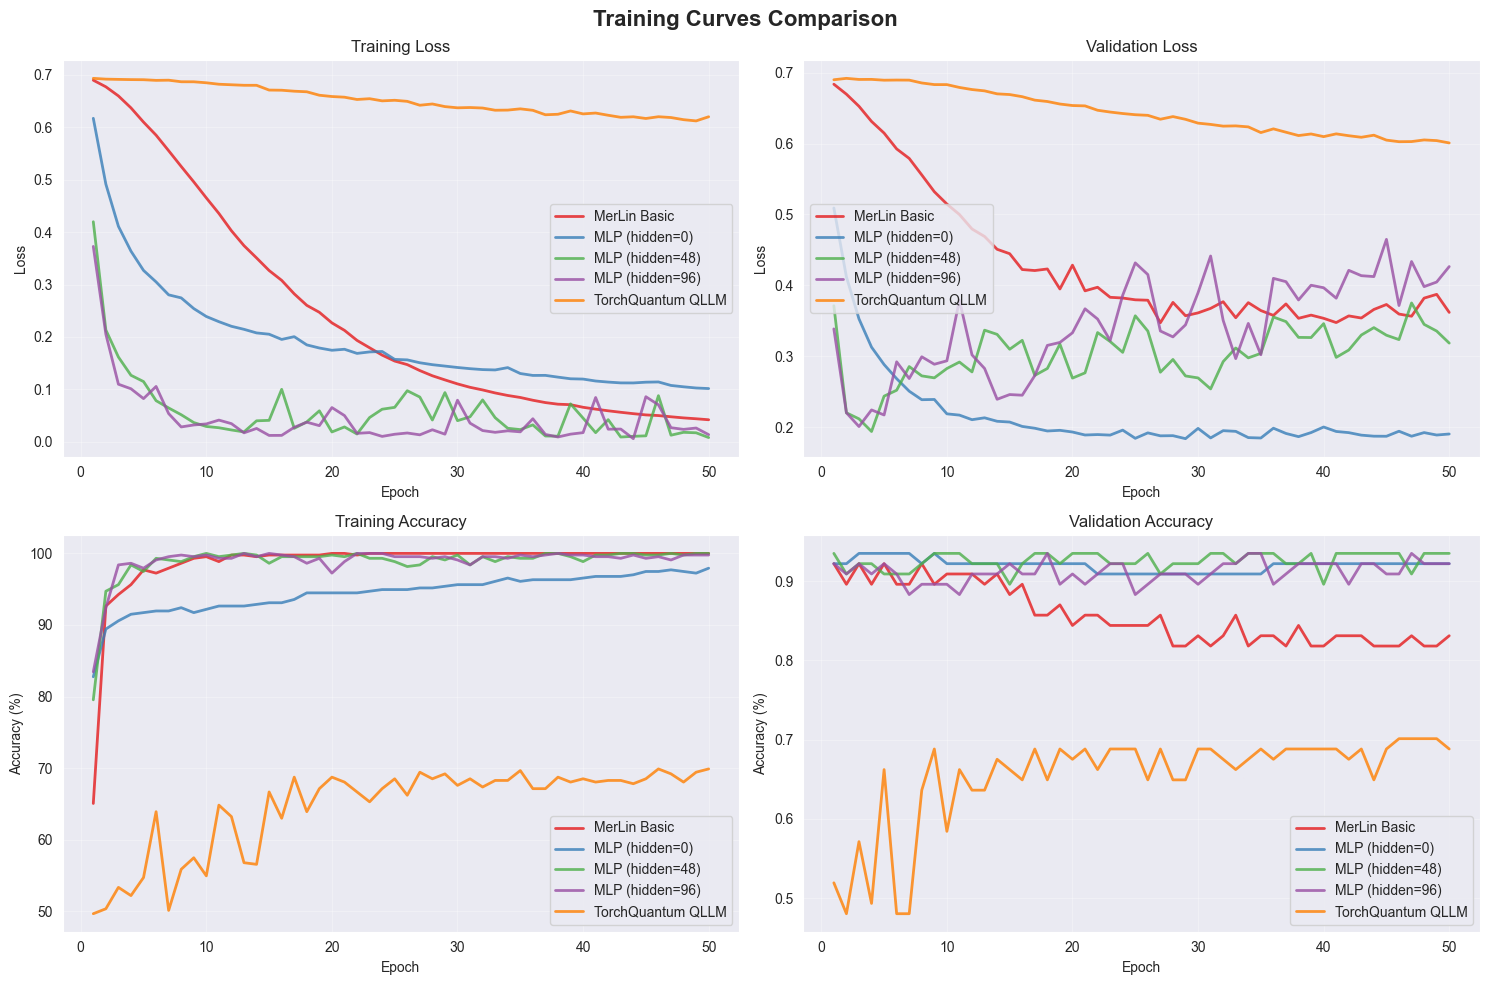

In [37]:
fig = plot_training_curves(results)

#### Key Observations
**Training Loss Analysis**

- MLP models show smooth, consistent convergence with training loss dropping steadily to very low values (near 0)
- MerLin Basic demonstrates good convergence but plateaus at a higher loss (~0.04)
- TorchQuantum QLLM shows the poorest convergence, plateating around 0.6 loss

**Validation Loss Patterns**

- MLP (hidden=0) shows excellent generalization with validation loss stabilizing around 0.19
- MLP (hidden=48) and (hidden=96) exhibit more erratic validation loss curves with higher variance, suggesting potential overfitting
- MerLin Basic validation loss becomes unstable after epoch 15, indicating overfitting
- TorchQuantum QLLM maintains high validation loss (~0.6), indicating poor learning

**Overfitting Analysis**

- MLP (hidden=0): Shows the best bias-variance tradeoff with stable validation performance
- MLP (hidden=48/96): Clear signs of overfitting - training accuracy reaches 100% while validation accuracy fluctuates around 93%
- MerLin Basic: Severe overfitting - training accuracy hits 100% early but validation accuracy degrades from ~92% to ~83%

**Training Efficiency**

- MLP models converge much faster (5-6 seconds) compared to others
- TorchQuantum QLLM takes significantly longer (95 seconds) with poor results
- MerLin Basic takes moderate time (42 seconds) but shows overfitting

*Recommendations*

- MLP (hidden=0) appears optimal for this task - simpler architecture generalizes better
- Larger MLP architectures (48, 96 hidden units) may need regularization techniques
- MerLin Basic would benefit from early stopping around epoch 15
- TorchQuantum QLLM may need architecture redesign or different hyperparameters

### Let's have a closer look at the data


Now that we have extracted embeddings from our pretrained model, a natural question arises: **how separable are these learned representations?** In other words, do the embeddings capture meaningful patterns that make classification easier, or are the classes still entangled in the high-dimensional space?

To answer this question, we'll use **t-SNE (t-Distributed Stochastic Neighbor Embedding)** to project our high-dimensional embeddings into 2D space. This visualization technique preserves local neighborhood structures, allowing us to see whether:

1. **Samples from the same class cluster together** (indicating good representation learning)
2. **Different classes are well-separated** (suggesting the classification task should be relatively easy)
3. **There are clear decision boundaries** between classes

If we observe tight, well-separated clusters, it suggests that the pretrained model has learned meaningful representations for this task. Conversely, if the classes are heavily overlapping, it indicates that additional learning or feature engineering might be needed.

Let's create our t-SNE visualization:

Running t-SNE on 9101 samples with 768 features...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9101 samples in 0.001s...
[t-SNE] Computed neighbors for 9101 samples in 0.603s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9101
[t-SNE] Computed conditional probabilities for sample 2000 / 9101
[t-SNE] Computed conditional probabilities for sample 3000 / 9101
[t-SNE] Computed conditional probabilities for sample 4000 / 9101
[t-SNE] Computed conditional probabilities for sample 5000 / 9101
[t-SNE] Computed conditional probabilities for sample 6000 / 9101
[t-SNE] Computed conditional probabilities for sample 7000 / 9101
[t-SNE] Computed conditional probabilities for sample 8000 / 9101
[t-SNE] Computed conditional probabilities for sample 9000 / 9101
[t-SNE] Computed conditional probabilities for sample 9101 / 9101
[t-SNE] Mean sigma: 7.703431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.858437
[t-SNE] KL divergence after 1000 iteratio

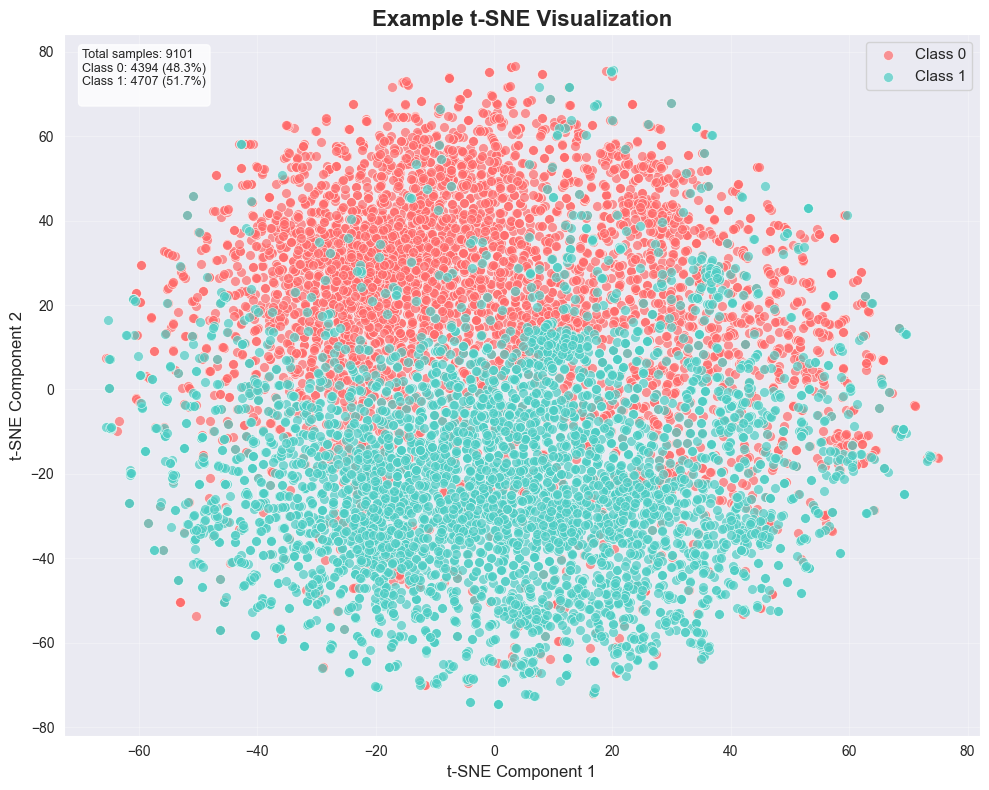

In [38]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


def plot_tsne_embeddings(
    embeddings,
    labels,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    figsize=(10, 8),
    colors=None,
    title="t-SNE Visualization of Training Embeddings",
    alpha=0.7,
    s=50,
):
    """
    Plot t-SNE visualization of training embeddings with binary color coding.

    Parameters:
    -----------
    embeddings : array-like, shape (n_samples, n_features)
        The training embeddings/features to visualize
    labels : array-like, shape (n_samples,)
        Binary labels (0/1 or any two distinct values)
    perplexity : float, default=30
        t-SNE perplexity parameter
    n_iter : int, default=1000
        Number of iterations for t-SNE
    random_state : int, default=42
        Random seed for reproducibility
    figsize : tuple, default=(10, 8)
        Figure size
    colors : list, default=None
        List of two colors for the binary labels. If None, uses default colors
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    alpha : float, default=0.7
        Point transparency
    s : int, default=50
        Point size

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The matplotlib figure object
    tsne_results : ndarray
        The 2D t-SNE coordinates
    """

    # Convert to numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Get unique labels
    unique_labels = np.unique(labels)

    # Standardize the embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    # Run t-SNE
    print(
        f"Running t-SNE on {embeddings.shape[0]} samples with {embeddings.shape[1]} features..."
    )
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=n_iter,
        random_state=random_state,
        verbose=1,
    )

    tsne_results = tsne.fit_transform(embeddings_scaled)

    # Set up colors
    if colors is None:
        colors = ["#FF6B6B", "#4ECDC4"]  # Red and teal

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot each class
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(
            tsne_results[mask, 0],
            tsne_results[mask, 1],
            c=colors[i],
            label=f"Class {label}",
            alpha=alpha,
            s=s,
            edgecolors="white",
            linewidth=0.5,
        )

    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel("t-SNE Component 1", fontsize=12)
    ax.set_ylabel("t-SNE Component 2", fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Add some statistics to the plot
    class_counts = [np.sum(labels == label) for label in unique_labels]
    stats_text = f"Total samples: {len(labels)}\n"
    for _i, (label, count) in enumerate(zip(unique_labels, class_counts)):
        stats_text += f"Class {label}: {count} ({count / len(labels) * 100:.1f}%)\n"

    ax.text(
        0.02,
        0.98,
        stats_text,
        transform=ax.transAxes,
        verticalalignment="top",
        fontsize=9,
        bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.8},
    )

    plt.tight_layout()

    plt.savefig("tSNE-test.png", dpi=300, bbox_inches="tight")
    print("Plot saved to: tSNE.png")

    return fig, tsne_results


fig, tsne_coords = plot_tsne_embeddings(
    embeddings=test_embeddings,
    labels=test_dataset["label"],
    title="Example t-SNE Visualization",
)
plt.show()

## Model Selection Guide

Here's a guide for when to use each model type:

In [39]:
print("=" * 70)
print("MODEL SELECTION GUIDE")
print("=" * 70)

models_guide = {
    "merlin-basic": {
        "description": "Basic photonic quantum classifier",
        "use_case": "Standard quantum ML experiments",
        "pros": ["Well-established quantum approach", "Moderate complexity"],
        "cons": ["Straightforward approach that can lead to subpar results"],
    },
    "merlin-parallel": {
        "description": "Parallel quantum encoding for efficiency",
        "use_case": "A more complex approach",
        "pros": ["Parallel processing"],
        "cons": ["More complex architecture"],
    },
    "merlin-expectation": {
        "description": "Expectation-based quantum measurements",
        "use_case": "When you want expectation value outputs",
        "pros": ["Direct expectation computation"],
        "cons": ["May have different convergence properties"],
    },
    "merlin-kernel": {
        "description": "Quantum kernel method with SetFit",
        "use_case": "Few-shot learning, kernel-based approaches",
        "pros": ["No gradient training needed", "Good for few-shot"],
        "cons": ["Expensive kernel computation", "Memory intensive"],
    },
    "torchquantum": {
        "description": "Variational quantum circuits",
        "use_case": "Gate-based quantum ML research",
        "pros": ["Flexible VQC design", "Standard quantum ML"],
        "cons": ["Requires careful parameter initialization"],
    },
    "mlps": {
        "description": "Classical neural networks",
        "use_case": "Baseline comparisons, fast prototyping",
        "pros": ["Fast training", "Well understood", "Multiple architectures"],
        "cons": ["Very simple models"],
    },
    "svm": {
        "description": "Support Vector Machines",
        "use_case": "Strong classical baselines",
        "pros": ["No hyperparameter tuning", "Robust"],
        "cons": ["Limited scalability"],
    },
    "log-reg": {
        "description": "Logistic Regression",
        "use_case": "Simple, fast baselines",
        "pros": ["Very fast", "Interpretable"],
        "cons": ["Limited expressivity"],
    },
}

for model_name, info in models_guide.items():
    print(f"\n🔹 {model_name.upper()}")
    print(f"   Description: {info['description']}")
    print(f"   Use case: {info['use_case']}")
    print(f"   Pros: {', '.join(info['pros'])}")
    print(f"   Cons: {', '.join(info['cons'])}")
    print("-" * 50)

MODEL SELECTION GUIDE

🔹 MERLIN-BASIC
   Description: Basic photonic quantum classifier
   Use case: Standard quantum ML experiments
   Pros: Well-established quantum approach, Moderate complexity
   Cons: Straightforward approach that can lead to subpar results
--------------------------------------------------

🔹 MERLIN-PARALLEL
   Description: Parallel quantum encoding for efficiency
   Use case: A more complex approach
   Pros: Parallel processing
   Cons: More complex architecture
--------------------------------------------------

🔹 MERLIN-EXPECTATION
   Description: Expectation-based quantum measurements
   Use case: When you want expectation value outputs
   Pros: Direct expectation computation
   Cons: May have different convergence properties
--------------------------------------------------

🔹 MERLIN-KERNEL
   Description: Quantum kernel method with SetFit
   Use case: Few-shot learning, kernel-based approaches
   Pros: No gradient training needed, Good for few-shot
   Cons

## Running Models from Command Line

Here are example commands to run each model type:

In [40]:
print("=" * 70)
print("COMMAND LINE EXAMPLES")
print("=" * 70)

commands = {
    "MerLin Basic": "python main.py --model merlin-basic --quantum-modes 8 --hidden-dim 100",
    "MerLin Parallel": "python main.py --model merlin-parallel --e-dim 2 --quantum-modes 8",
    "MerLin Expectation": "python main.py --model merlin-expectation --quantum-modes 8",
    "MerLin Kernel": "python main.py --model merlin-kernel --quantum-modes 8 --photons 4",
    "TorchQuantum": 'python main.py --model torchquantum --encoder-configs \'[{"n_qubits": 10, "n_layers": 1, "connectivity": 1}]\'',
    "MLPs": "python main.py --model mlps --hidden-dim 100",
    "SVM": "python main.py --model svm",
    "Logistic Regression": "python main.py --model log-reg",
}

for model_name, command in commands.items():
    print(f"\n📋 {model_name}:")
    print(f"   {command}")

print("\n\n📝 Additional Parameters:")
print("   --epochs N          Number of training epochs (default: 5)")
print("   --learning-rate LR  Learning rate (default: 1e-5)")
print("   --batch-size N      Batch size (default: 16)")
print("   --samples-per-class N  Few-shot samples (default: 8)")
print("   --device DEVICE     cuda/cpu/auto (default: auto)")
print("   --verbose           Enable verbose output")
print("   --seed N            Random seed (default: 42)")

COMMAND LINE EXAMPLES

📋 MerLin Basic:
   python main.py --model merlin-basic --quantum-modes 8 --hidden-dim 100

📋 MerLin Parallel:
   python main.py --model merlin-parallel --e-dim 2 --quantum-modes 8

📋 MerLin Expectation:
   python main.py --model merlin-expectation --quantum-modes 8

📋 MerLin Kernel:
   python main.py --model merlin-kernel --quantum-modes 8 --photons 4

📋 TorchQuantum:
   python main.py --model torchquantum --encoder-configs '[{"n_qubits": 10, "n_layers": 1, "connectivity": 1}]'

📋 MLPs:
   python main.py --model mlps --hidden-dim 100

📋 SVM:
   python main.py --model svm

📋 Logistic Regression:
   python main.py --model log-reg


📝 Additional Parameters:
   --epochs N          Number of training epochs (default: 5)
   --learning-rate LR  Learning rate (default: 1e-5)
   --batch-size N      Batch size (default: 16)
   --samples-per-class N  Few-shot samples (default: 8)
   --device DEVICE     cuda/cpu/auto (default: auto)
   --verbose           Enable verbose outp

## Summary

This notebook has demonstrated the 8 different model architectures available in the QLLM framework:

### Quantum Models:
- **MerLin Family** (photonic quantum computing): Basic, Parallel, Expectation, Kernel
- **TorchQuantum** (gate-based VQCs): Variational quantum circuits

### Classical Models:
- **MLPs**: Multiple architectures for comparison
- **SVM**: Support Vector Machines with different configurations
- **Logistic Regression**: Simple linear classifier

Each model has different strengths and is suitable for different experimental scenarios. The quantum models explore different approaches to quantum machine learning, while classical models provide strong baselines for comparison.

To get started:
1. Ensure you have embeddings in the `./embeddings` directory
2. Choose a model based on your research goals
3. Run the corresponding command from the examples above
4. Compare results across different architectures

Happy experimenting! 🚀